In [44]:
import numpy as np
import pandas as pd

In [45]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing 
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from datetime import datetime
from xgboost import XGBClassifier
import lightgbm as lgb
#snapboost implementation
from pai4sk import BoostingMachine

In [46]:
pokemon_df = pd.read_csv("pokemon_categorical.csv")

In [47]:
#basic info of dataset
df2 = pokemon_df.select_dtypes(include = ['float64', 'int64'])
df3 = pokemon_df.select_dtypes(include = ['object'])
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        801 non-null    float64
 1   against_dark       801 non-null    float64
 2   against_dragon     801 non-null    float64
 3   against_electric   801 non-null    float64
 4   against_fairy      801 non-null    float64
 5   against_fight      801 non-null    float64
 6   against_fire       801 non-null    float64
 7   against_flying     801 non-null    float64
 8   against_ghost      801 non-null    float64
 9   against_grass      801 non-null    float64
 10  against_ground     801 non-null    float64
 11  against_ice        801 non-null    float64
 12  against_normal     801 non-null    float64
 13  against_poison     801 non-null    float64
 14  against_psychic    801 non-null    float64
 15  against_rock       801 non-null    float64
 16  against_steel      801 non

In [49]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   abilities      801 non-null    object
 1   classfication  801 non-null    object
 2   japanese_name  801 non-null    object
 3   name           801 non-null    object
 4   type1          801 non-null    object
 5   type2          417 non-null    object
dtypes: object(6)
memory usage: 37.7+ KB


In [50]:
df3.head()

,abilities,classfication,japanese_name,name,type1,type2
0,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigidaneフシギダネ,Bulbasaur,grass,poison
1,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigisouフシギソウ,Ivysaur,grass,poison
2,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigibanaフシギバナ,Venusaur,grass,poison
3,"['Blaze', 'Solar Power']",Lizard Pokémon,Hitokageヒトカゲ,Charmander,fire,NaN
4,"['Blaze', 'Solar Power']",Flame Pokémon,Lizardoリザード,Charmeleon,fire,NaN


In [51]:
## from preprocessing, use LabelEncoder, we want to encode 
le = preprocessing.LabelEncoder() 
labels = le.fit_transform(pokemon_df['type1'])
print(len(le.classes_)) 
print(le.classes_)

18
['bug' 'dark' 'dragon' 'electric' 'fairy' 'fighting' 'fire' 'flying'
 'ghost' 'grass' 'ground' 'ice' 'normal' 'poison' 'psychic' 'rock' 'steel'
 'water']


water       114
normal      105
grass        78
bug          72
psychic      53
fire         52
rock         45
electric     39
ground       32
poison       32
dark         29
fighting     28
dragon       27
ghost        27
steel        24
ice          23
fairy        18
flying        3
Name: type1, dtype: int64

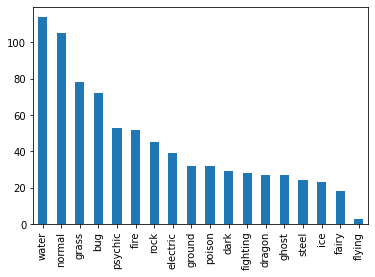

In [52]:
pokemon_df.type1.value_counts().plot.bar()
pokemon_df.type1.value_counts() 

flying      95
ground      34
poison      34
fairy       29
psychic     29
fighting    25
steel       22
dark        21
grass       20
dragon      17
water       17
ice         15
ghost       14
rock        14
fire        13
electric     9
bug          5
normal       4
Name: type2, dtype: int64

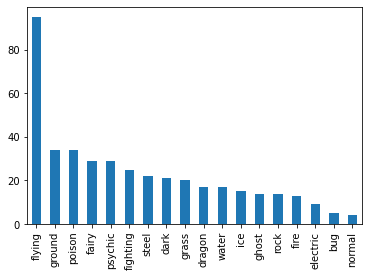

In [53]:
pokemon_df.type2.value_counts().plot.bar()
pokemon_df.type2.value_counts() 

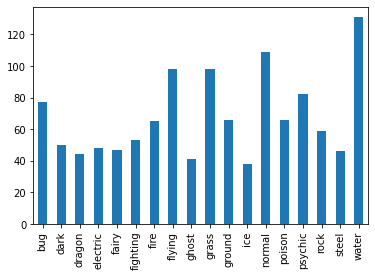

In [54]:
# and the accurate plot, keep in mind not every pokemon has 2 types
(pokemon_df.type1.value_counts() + pokemon_df.type2.value_counts()).plot.bar()
## and the accurate plot, keep in mind not every pokemon has 2 types
(pokemon_df.type1.value_counts() + pokemon_df.type2.value_counts()).plot.bar()

In [55]:
pokemon_df['type2'].fillna(value='None', inplace=True) 

In [56]:
abilitiesList = []
for n in range(len(pokemon_df.abilities)):
    for ability in pokemon_df.abilities.iloc[n]:
        if ability not in abilitiesList:
            abilitiesList.append(ability)
            
print('Number of unique abilities: ', len(abilitiesList))

Number of unique abilities:  56


In [57]:
data = {
    'attack': pokemon_df['attack'],
    'defense': pokemon_df['defense'],
    'sp_attack': pokemon_df['sp_attack'],
    'sp_defense': pokemon_df['sp_defense'],
    'type2': pokemon_df.type2,
    'type1': pokemon_df['type1']
}
data = pd.DataFrame(data)
## look for columns with 'against' and join them
data = pokemon_df.filter(like='against').join(data) 

X = data.drop('type1', axis=1)
y = data['type1']
print(list(X))
X

['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water', 'attack', 'defense', 'sp_attack', 'sp_defense', 'type2']


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,against_poison,against_psychic,against_rock,against_steel,against_water,attack,defense,sp_attack,sp_defense,type2
0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,2.0,1.0,1.0,0.5,49,49,65,65,poison
1,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,2.0,1.0,1.0,0.5,62,63,80,80,poison
2,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,1.0,2.0,1.0,1.0,0.5,100,123,122,120,poison
3,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,1.0,1.0,2.0,0.5,2.0,52,43,60,50,None
4,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,1.0,1.0,2.0,0.5,2.0,64,58,80,65,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,...,0.0,0.5,1.0,0.5,1.0,101,103,107,101,flying
797,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,...,0.0,0.5,0.5,0.5,0.5,181,131,59,31,steel
798,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,...,1.0,0.0,1.0,1.0,0.5,101,53,97,53,dragon
799,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,...,1.0,0.5,1.0,1.0,1.0,107,101,127,89,None


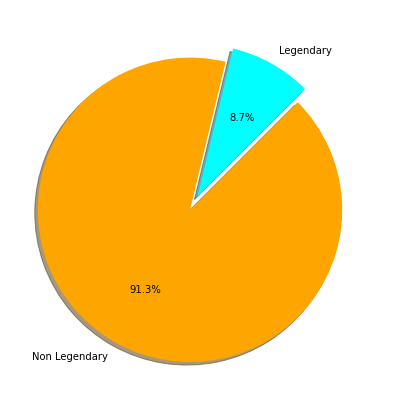

In [58]:
fig = plt.figure(figsize=(7,7))

colors = ["aqua", "orange"]
pokeLeg = pokemon_df[pokemon_df['is_legendary'] == True]
pokeNon = pokemon_df[pokemon_df['is_legendary'] == False]

legDist = [pokeLeg['name'].count(), pokeNon['name'].count()]
legPie = plt.pie(legDist,
                 labels= ['Legendary', 'Non Legendary'], 
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

/home/users/NIE_IBM_grm4/conda3/envs/wmlce/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/users/NIE_IBM_grm4/conda3/envs/wmlce/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


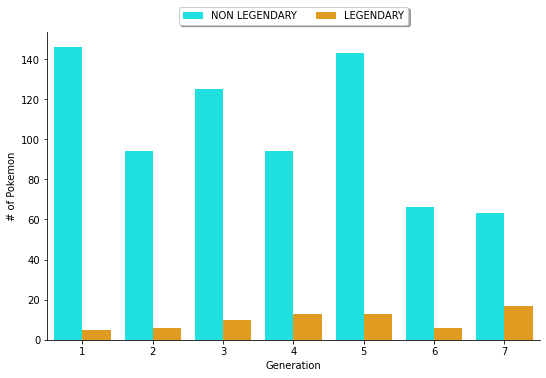

In [59]:
## correlation between legendary pokemon and non-legendary per generation
colors = ["aqua", "orange"]
g = sns.factorplot(
    x='generation', 
    data=pokemon_df,
    kind='count', 
    hue='is_legendary',
    palette=colors, 
    size=5, 
    aspect=1.5,
    legend=False,
    ).set_axis_labels('Generation', '# of Pokemon')

g.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),  shadow=True, ncol=2, labels=['NON LEGENDARY','LEGENDARY'])
plt.show()

In [60]:
## Not usually a good sign since there is not enough data on what is a legendary
## Maybe there's a very strong correlation we can exploit
## High attack and defense correlation|

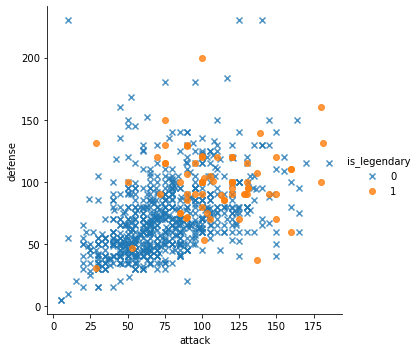

In [61]:
sns.lmplot(x='attack', y='defense', hue='is_legendary', fit_reg=False, data=pokemon_df, markers = ['x', 'o'])

In [62]:
leg = pokemon_df[pokemon_df['is_legendary'] == True]
leg_total = leg['base_total'].mean()
non_leg_total = pokemon_df[pokemon_df['is_legendary'] != True]['base_total'].mean()

In [63]:
pd.DataFrame([leg_total, non_leg_total], index=['Legendary', 'non-Legendary'], columns=['Average Total'])

,Average Total
Legendary,615.257143
non-Legendary,410.481532


In [64]:
isLegendary = pd.get_dummies(pokemon_df['is_legendary'], drop_first=True)
lr_df = pokemon_df[['base_total', 'capture_rate']]
lr_df = pd.concat([lr_df, isLegendary], axis=1)

In [65]:
lr_df.columns = ['Base Total', 'Catch Rate', 'Is Legendary']
lr_df.head()

,Base Total,Catch Rate,Is Legendary
0,318,45,0
1,405,45,0
2,625,45,0
3,309,45,0
4,405,45,0


In [66]:
lr_df.tail()

,Base Total,Catch Rate,Is Legendary
796,570,25,1
797,570,255,1
798,570,15,1
799,600,3,1
800,600,3,1


In [67]:
X = lr_df.drop('Is Legendary', axis = 1)
y = lr_df['Is Legendary']

In [68]:
#trying to predict the is legendary from base total and catch rate

In [69]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [70]:
booster = BoostingMachine(objective='logloss', num_round=50, min_max_depth=1, max_max_depth=6,
                             learning_rate=0.01, random_state=None, use_gpu=False, n_threads=1)
t1=datetime.now()
booster.fit(x_train.to_numpy(), y_train.to_numpy())
t2=datetime.now()
execution_time_snap_boost = t2-t1
t3 = datetime.now()
ypred = booster.predict(np.ascontiguousarray(x_test))
t4 = datetime.now()
accuracy_snap_boost = round(roc_auc_score(np.ascontiguousarray(y_test),ypred),2)
print("Accuracy score = ",accuracy_snap_boost*100,"%")
print("Execution time = ",execution_time_snap_boost)
print("Prediction time = ",t4-t3)
snap_boost_train_time = t2-t1

Accuracy score =  98.0 %
Execution time =  0:00:00.017981
Prediction time =  0:00:00.000727


In [71]:
#xgboost implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [72]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

In [73]:
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)
scoring = 'roc_auc'

/home/users/NIE_IBM_grm4/conda3/envs/wmlce/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [74]:
t1=datetime.now()
results = cross_val_score(model, X, y, cv=kfold, scoring = scoring)
t2=datetime.now()
print( "AUC: %.3f (%.3f)" % (results.mean(), results.std()) )
print("Training time = ",t2-t1)
accuracy_xgb = results.mean()
xgb_train_time = t2-t1

AUC: 0.972 (0.066)
Training time =  0:00:00.342645


In [75]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [76]:
train_data=lgb.Dataset(x_train,label=y_train)
params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
params['metric'] = ['auc', 'binary_logloss']
num_round=50

In [77]:
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
t3 = datetime.now()
ypred2=lgbm.predict(x_test)
t4 = datetime.now()

In [78]:
#we need to make the ypred of int format
for i in range(0,241): ## 30% ##
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0

In [79]:
ypred2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [80]:
accuracy_lgbm = accuracy_score(ypred2,y_test)

In [81]:
execution_time_lgbm = t2-t1
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  96.6804979253112 %
Execution time =  0:00:00.014214
Prediction time =  0:00:00.002532


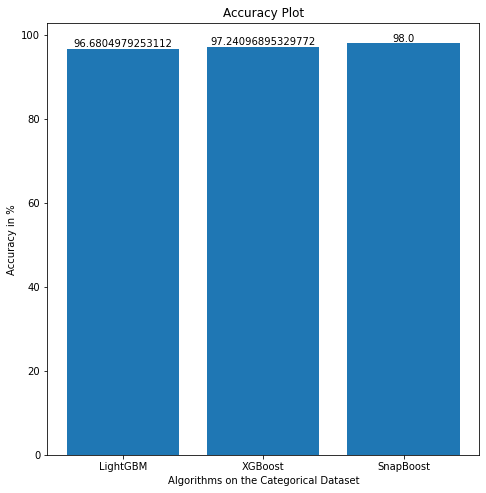

In [82]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Categorical Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

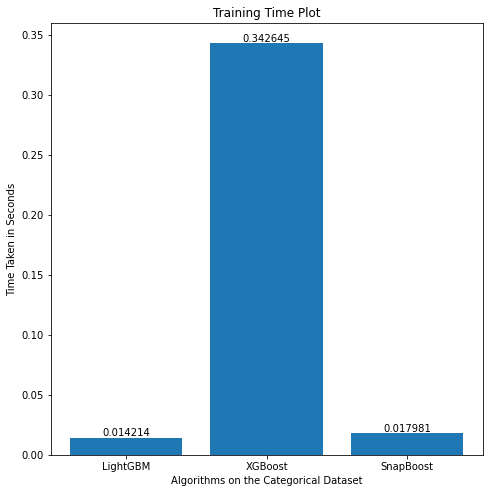

In [83]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(snap_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (6,6))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Categorical Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()